In [321]:
import numpy as np
from scipy.sparse import random
import matplotlib.pyplot as plot

In [322]:
V = 2 # number of features
R = 20 # size of reservoir
LEARN_TIME = 1#10
READOUT_TIME = 1#50
LEARNING_RATE = 0.001
DENSITY = 0.25
NUM_ITERATIONS = 100

Wr = random(R, R, density=DENSITY).toarray()
# Win = random(V, R, density=DENSITY).toarray()
Win = np.random.random((V , R))
W_readout = np.random.random((R + 1, 1))

X = np.array([[0, 0, 1, 1], [0, 1, 0, 1]])
h = np.random.random((R, 1))
y = np.array([0, 0, 0, 1]) 
delta = []

In [323]:
def advance_state(activation_function):
    global h, x, Win, Wr, delta
    h_new = np.matmul(Win.transpose(), x) + np.matmul(Wr.transpose(), h)
    h_new = activation_function(h_new)
    delta.append(np.sum(h_new - h))
    h = h_new

In [324]:
def relu(x):
    if x > 0:
	    return x
    else:
        return 0
    
def linear(x):
	return x

def sigmoid(x):
	return 1/(1 + np.exp(-x))

In [325]:
def forward(x):
	global Win, Wr, h
	predict = np.matmul(Win.transpose(), x) + np.matmul(Wr.transpose(), h)
	predict = np.vstack(([1], predict))
	return np.matmul(W_readout.transpose(), predict)

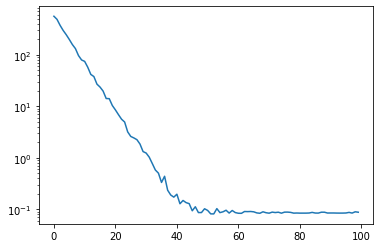

0.08741698681449532 0.08105554654678801


In [326]:
losses = []
errors = []

for epoch in range(NUM_ITERATIONS):
	permutation = np.random.permutation(4)
	
	batch_error = 0
	
	for datapoint in permutation:
		x = X[:, datapoint].reshape(2, 1)
		label = y[datapoint]
		
		for iteration in range(LEARN_TIME):
		    advance_state(sigmoid)

		error = 0
		for iteration in range(READOUT_TIME):
			predict = forward(x)
			batch_error += 2 * (predict - label)
			errors.append(np.square(error).item(0))
		
	W_readout = W_readout - LEARNING_RATE * batch_error / (permutation.size * READOUT_TIME)

	loss = 0
	for datapoint in range(4):
		x = X[:, datapoint].reshape(2, 1)
		loss += np.square(forward(x).item(0) - y[datapoint].item(0))

	losses.append(loss / 4)
		
plot.plot(losses)
plot.yscale("log")
plot.show()

print(losses[-1], min(losses))

In [327]:
def threshold(x, THRESHOLD):
	if x > THRESHOLD:
		return 1
	return 0

In [328]:
for datapoint in range(4):
	x = X[:, datapoint].reshape(2,1)
	print(x, forward(x), threshold(forward(x), 0.5))


[[0]
 [0]] [[0.00686242]] 0
[[0]
 [1]] [[0.36753423]] 0
[[1]
 [0]] [[0.2483578]] 0
[[1]
 [1]] [[0.60902961]] 1
